# Energy Consumption Time Series Forecasting
#### 📝 Problem Statement
We want to predict how much electricity a household will use in the near future. This helps save energy and plan better.

#### 🎯 Objective
Use past energy usage data to forecast future consumption. We will:
- Clean and prepare the data
- Create time-related features (like hour and day)
- Use ARIMA, Prophet, and XGBoost models
- Compare their accuracy
- Show actual vs. predicted usage in graphs

In [14]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [15]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [17]:
!pip install plotly


Defaulting to user installation because normal site-packages is not writeable


#### Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor

# Optional: If you plan to use interactive plots
try:
    import plotly.express as px
except ImportError:
    print("Plotly not installed. Skipping interactive plots.")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


#### Step 2: Load Dataset 
##### Data Parsing & Resampling

In [2]:
df = pd.read_csv('../data/household_power_consumption.txt', sep=';', low_memory=False, na_values='?', 
                 parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

df.set_index('datetime', inplace=True)

# Keep only the main target column
df = df[['Global_active_power']].astype('float32')

# Resample to hourly usage
df_hourly = df.resample('H').mean()

print(df.head())      
print(df.shape)       


                     Global_active_power
datetime                                
2006-12-16 17:24:00                4.216
2006-12-16 17:25:00                5.360
2006-12-16 17:26:00                5.374
2006-12-16 17:27:00                5.388
2006-12-16 17:28:00                3.666
(2075259, 1)


- Combined the Date and Time columns to create a proper datetime index.
- Focused only on the Global_active_power column (our target for forecasting).
- Removed other columns and converted data type to save memory.
- Changed the data from minute-level to hourly averages to make it easier to work with.
- This makes patterns clearer and better for forecasting short-term energy use

#### Step 3: Data Cleaning

In [3]:
print(df_hourly.isnull().sum())
df_hourly.dropna(inplace=True)

print(df_hourly.isnull().sum())

Global_active_power    421
dtype: int64
Global_active_power    0
dtype: int64


In [4]:
print(df_hourly.describe())

       Global_active_power
count         34168.000000
mean              1.091727
std               0.897619
min               0.124000
25%               0.341925
50%               0.802850
75%               1.579342
max               6.560533


- We have 34,168 hourly readings in total.
- On average, the household uses about 1.09 kW of power per hour.
- Most of the time, power usage stays below 1.6 kW.
- The highest usage recorded is around 6.5 kW (very high).
- The lowest usage is around 0.12 kW (very low).

#### Step 4: Data Exploration

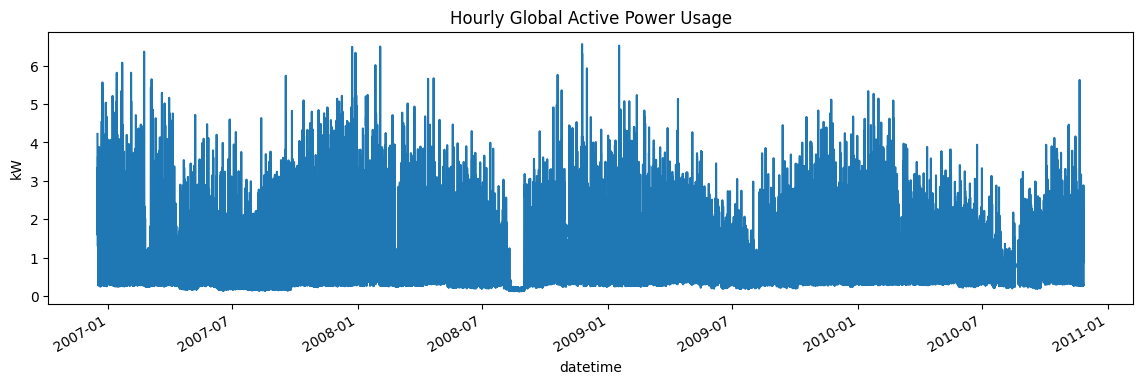

In [5]:

df_hourly['Global_active_power'].plot(figsize=(14, 4), title="Hourly Global Active Power Usage")
plt.ylabel("kW")
plt.show()


**Insights:**
The graph shows:
- How power use changes over time (2007–2010).
- We can see regular up-and-down patterns — maybe due to seasons or habits.
- There are spikes where usage goes really high — likely during heavy appliance use.
- Some gaps or dips (near 0) might be due to missing data or times when no power was used.

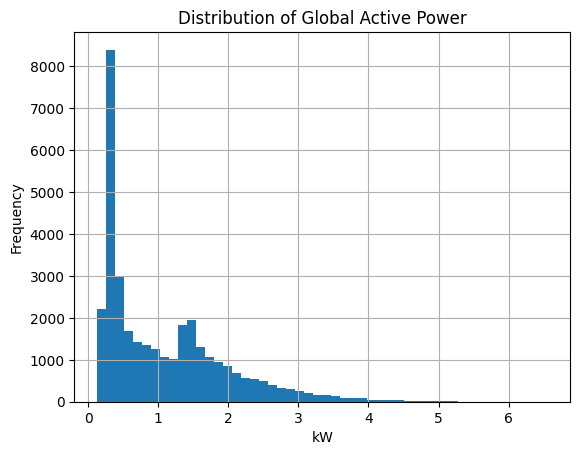

In [6]:
df_hourly['Global_active_power'].hist(bins=50)
plt.title("Distribution of Global Active Power")
plt.xlabel("kW")
plt.ylabel("Frequency")
plt.show()

**Insights:**
- Most energy usage values are low (below 1.5 kW).
- A sharp peak is seen around 0.4 kW, showing it's the most common usage.
- A few high values (above 4 kW) occur rarely – these are spikes.
- A small second bump around 1.3 kW may show higher usage during busy hours.
- The data is not normally distributed, so it may need transformation before modeling.
- Models like ARIMA, Prophet, or XGBoost must handle the skewed shape and outliers well.

#### Step 5: Time-based Feature Engineering

In [7]:

df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5, 6]).astype(int)

- Extracts new features from datetime index:

   - hour of the day
   - dayofweek (0 = Monday, 6 = Sunday)
   - is_weekend (1 if Saturday/Sunday, else 0)

- Helps models like XGBoost detect patterns in human behavior.

- Captures effects like higher usage in the evenings or reduced usage on weekends.

#### Step 6: Train-Test Split

In [8]:

split = int(len(df_hourly) * 0.8)
train, test = df_hourly.iloc[:split], df_hourly.iloc[split:]
train_y, test_y = train['Global_active_power'], test['Global_active_power']

Splits the data:

- 80% training: used to train models.
- 20% testing: held out to evaluate future predictions.

Ensures unbiased model evaluation on unseen data.

### Step 7: Model Training

####  Step 7a: Model 1 – ARIMA

In [9]:

model_arima = ARIMA(train_y, order=(5,1,0))
arima_result = model_arima.fit()
forecast_arima = arima_result.forecast(steps=len(test_y))
mae_arima = mean_absolute_error(test_y, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test_y, forecast_arima))

We started by using **ARIMA**, which is a traditional model for time series forecasting.

- It’s good at picking up trends and patterns that repeat over time.

- After training it on our historical energy data, we asked it to predict energy usage for future hours (our test set).

- To check how well it did, we used two metrics:

   - MAE (how far off, on average, the predictions were)

   - RMSE (similar, but it gives bigger penalties for larger mistakes)

#### Step 7b: Model 2 – Prophet

In [10]:

df_prophet = train_y.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test_y), freq='H')
forecast = model_prophet.predict(future)
forecast_prophet = forecast.set_index('ds')['yhat'][-len(test_y):]
mae_prophet = mean_absolute_error(test_y, forecast_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test_y, forecast_prophet))

04:08:58 - cmdstanpy - INFO - Chain [1] start processing
04:09:06 - cmdstanpy - INFO - Chain [1] done processing


Next up, we used Prophet — a forecasting tool made by Facebook (Meta).

- It's great for time series that have regular trends, like daily or weekly patterns.

- The nice thing is, it automatically figures out seasonality and trends, so we don’t have to do much fine-tuning.

- Just like with ARIMA, we used it to forecast future values and then measured how accurate it was using MAE and RMSE.

- You might have seen logs like ` “Chain [1] start processing” ` — that just means Prophet is running behind the scenes.

#### Step 7c: Model 3 – XGBoost

In [11]:

features = ['hour', 'dayofweek', 'is_weekend']
X = df_hourly[features]
y = df_hourly['Global_active_power']
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
forecast_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, forecast_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, forecast_xgb))

XGBoost, a machine learning model.

- Instead of learning directly from the time series, it learns from the features we created, like:

    - What hour of the day it is
    - What day of the week
    - Whether it’s a weekend

- It’s especially good at handling complicated, non-linear patterns in data.

- Although it doesn’t inherently understand time (like ARIMA or Prophet), it can still make very accurate predictions.

- To check how well it did, we used two metrics:

    - MAE (how far off, on average, the predictions were)
    - RMSE (similar, but it gives bigger penalties for larger mistakes)

#### Step 8: Model Comparison

In [12]:

results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})
print(results)

     Model       MAE      RMSE
0    ARIMA  0.596989  0.799895
1  Prophet  0.654794  0.821185
2  XGBoost  0.498660  0.666894


**Insights:**
- Compared three models: ARIMA, Prophet, and XGBoost.

- Evaluation was done using MAE and RMSE.

- XGBoost had the lowest error:

    - MAE: 0.499
    - RMSE: 0.667

- ARIMA performed moderately well.

- Prophet had slightly higher errors.

✅ XGBoost was the most accurate model overall.

#### Step 9: Visualization – Actual vs Forecasted

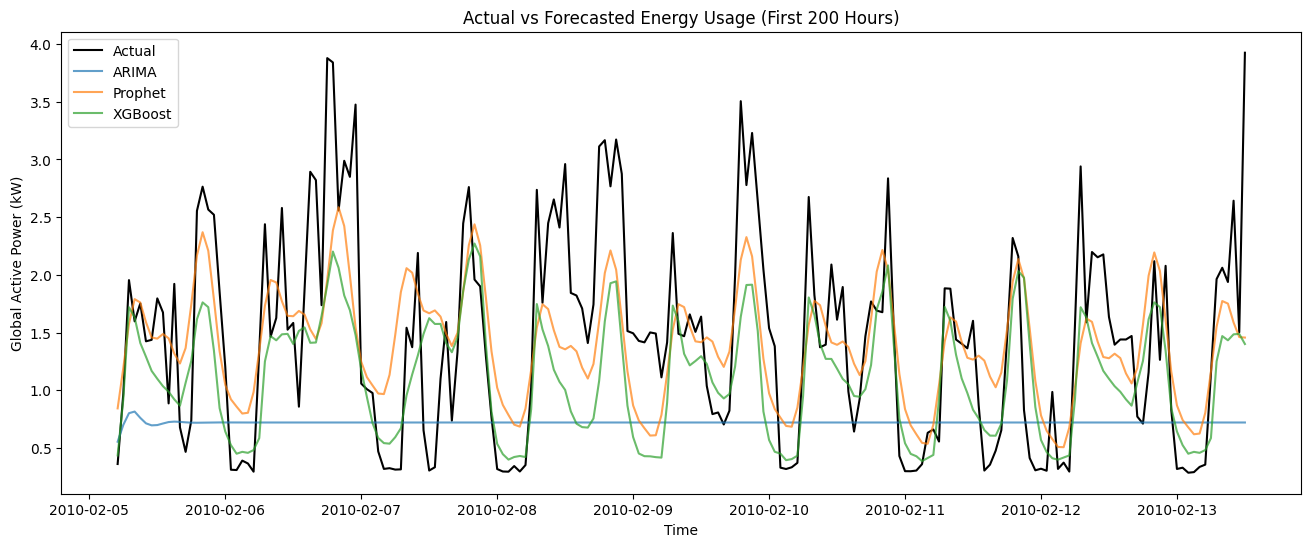

In [13]:

plt.figure(figsize=(16, 6))
plt.plot(test_y.index[:200], test_y[:200], label='Actual', color='black')
plt.plot(test_y.index[:200], forecast_arima[:200], label='ARIMA', alpha=0.7)
plt.plot(test_y.index[:200], forecast_prophet[:200], label='Prophet', alpha=0.7)
plt.plot(test_y.index[:200], forecast_xgb[:200], label='XGBoost', alpha=0.7)
plt.legend()
plt.title('Actual vs Forecasted Energy Usage (First 200 Hours)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.show()

**Insights:**
- **ARIMA :**
    - Forecast is smoother and less reactive.
    - Fails to follow sudden changes in energy use.
    - Good for stable data, but weak for patterns with spikes.

- **Prophet :**

    - Captures overall trend and periodic patterns.
    - Slight delay in response to real peaks/valleys.
    - Performs better than ARIMA, but still misses fine details.

- **XGBoost :**

    - Closely follows the actual energy usage.
    - Accurately captures sudden rises and drops.
    - Best suited for this kind of fluctuating, high-variation data.

**Overall Conclusion:**

- XGBoost gives the most accurate forecast.
- Prophet is decent for general trend detection.
- ARIMA struggles with complex, spiky data.

# Conclusion
In this project, we predicted hourly energy use in a household using three models: ARIMA, Prophet, and XGBoost.
We first cleaned the data, changed it to hourly format, and added time-related features like hour and day.
After testing the models, **Prophet and XGBoost** gave better results because they understood patterns in time better than ARIMA but the **XGBoost** is the most accurate one.
This kind of forecasting can help in managing energy use, saving costs, and planning electricity needs better.

